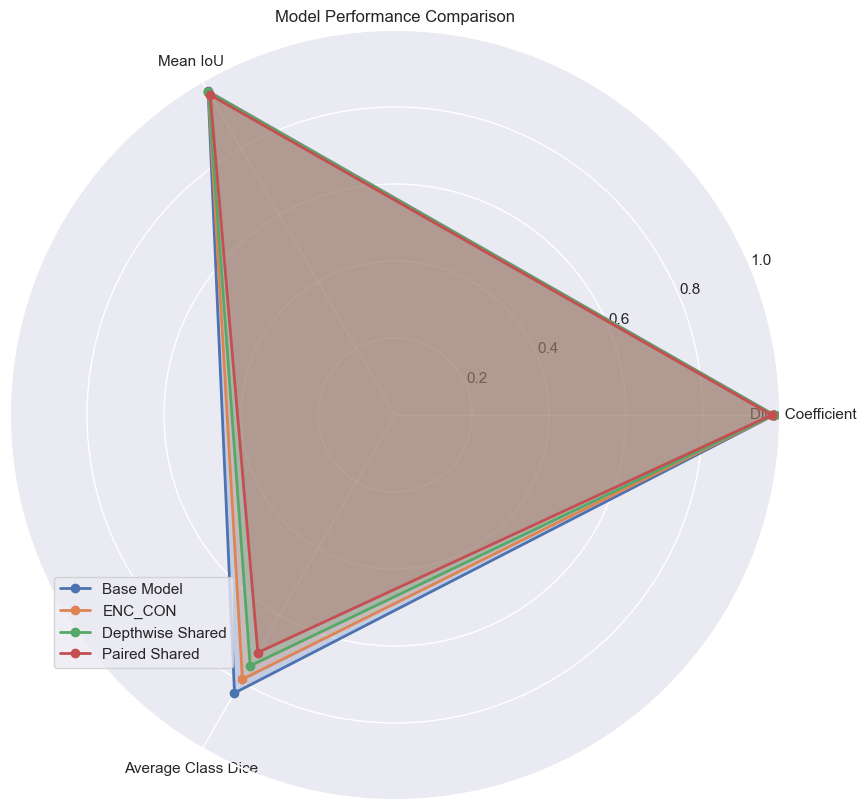

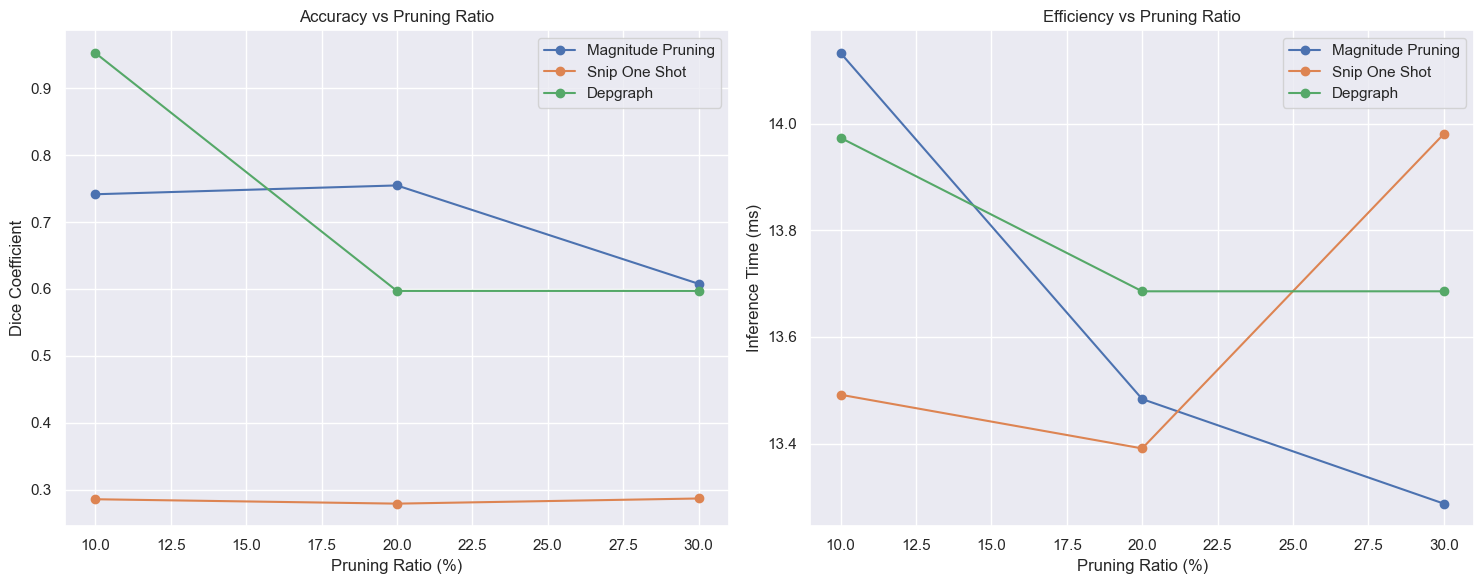

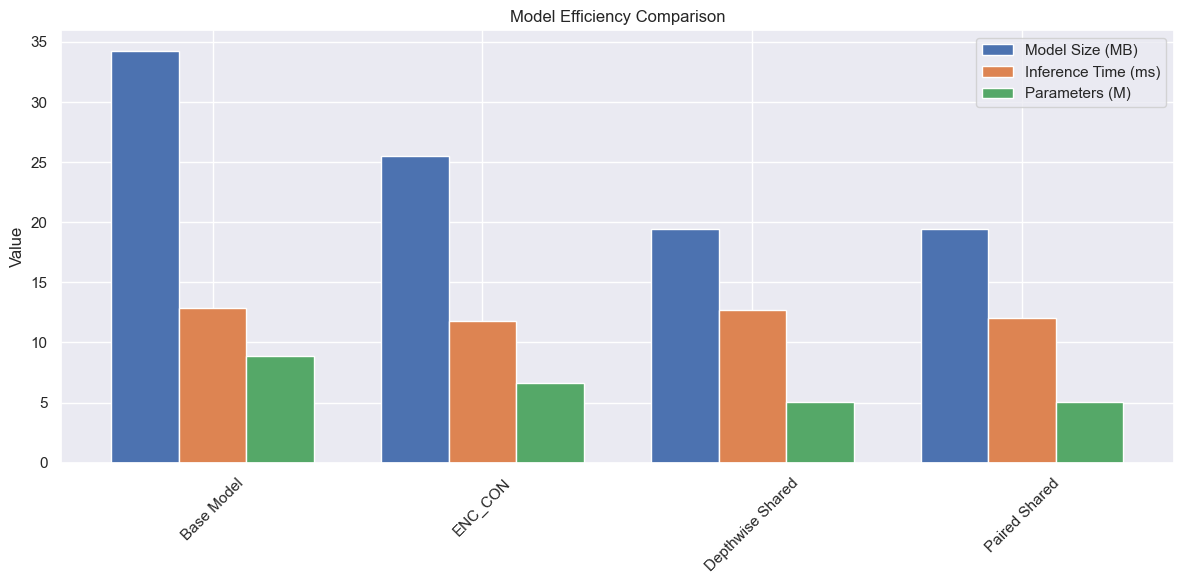

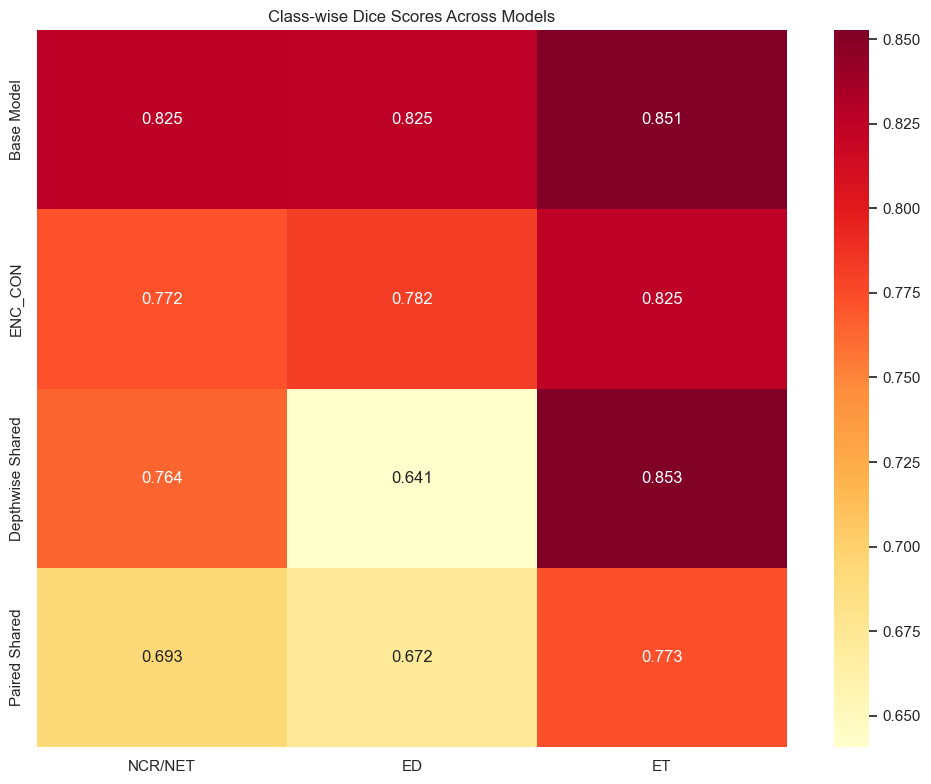

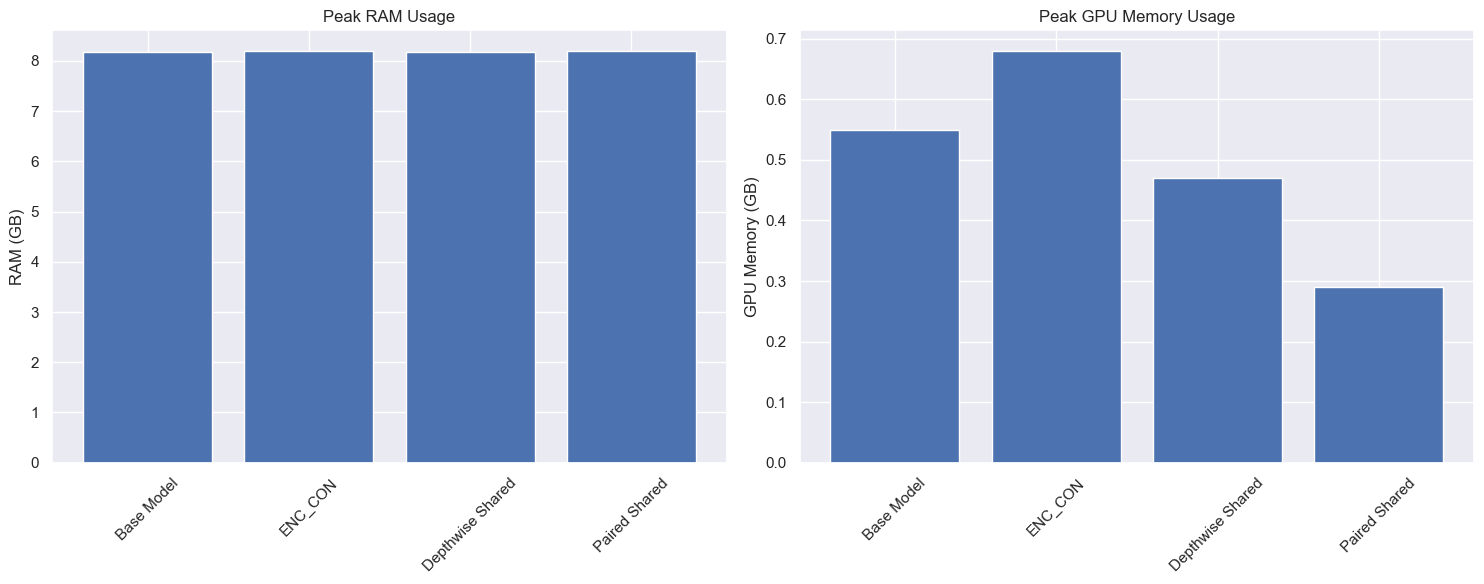

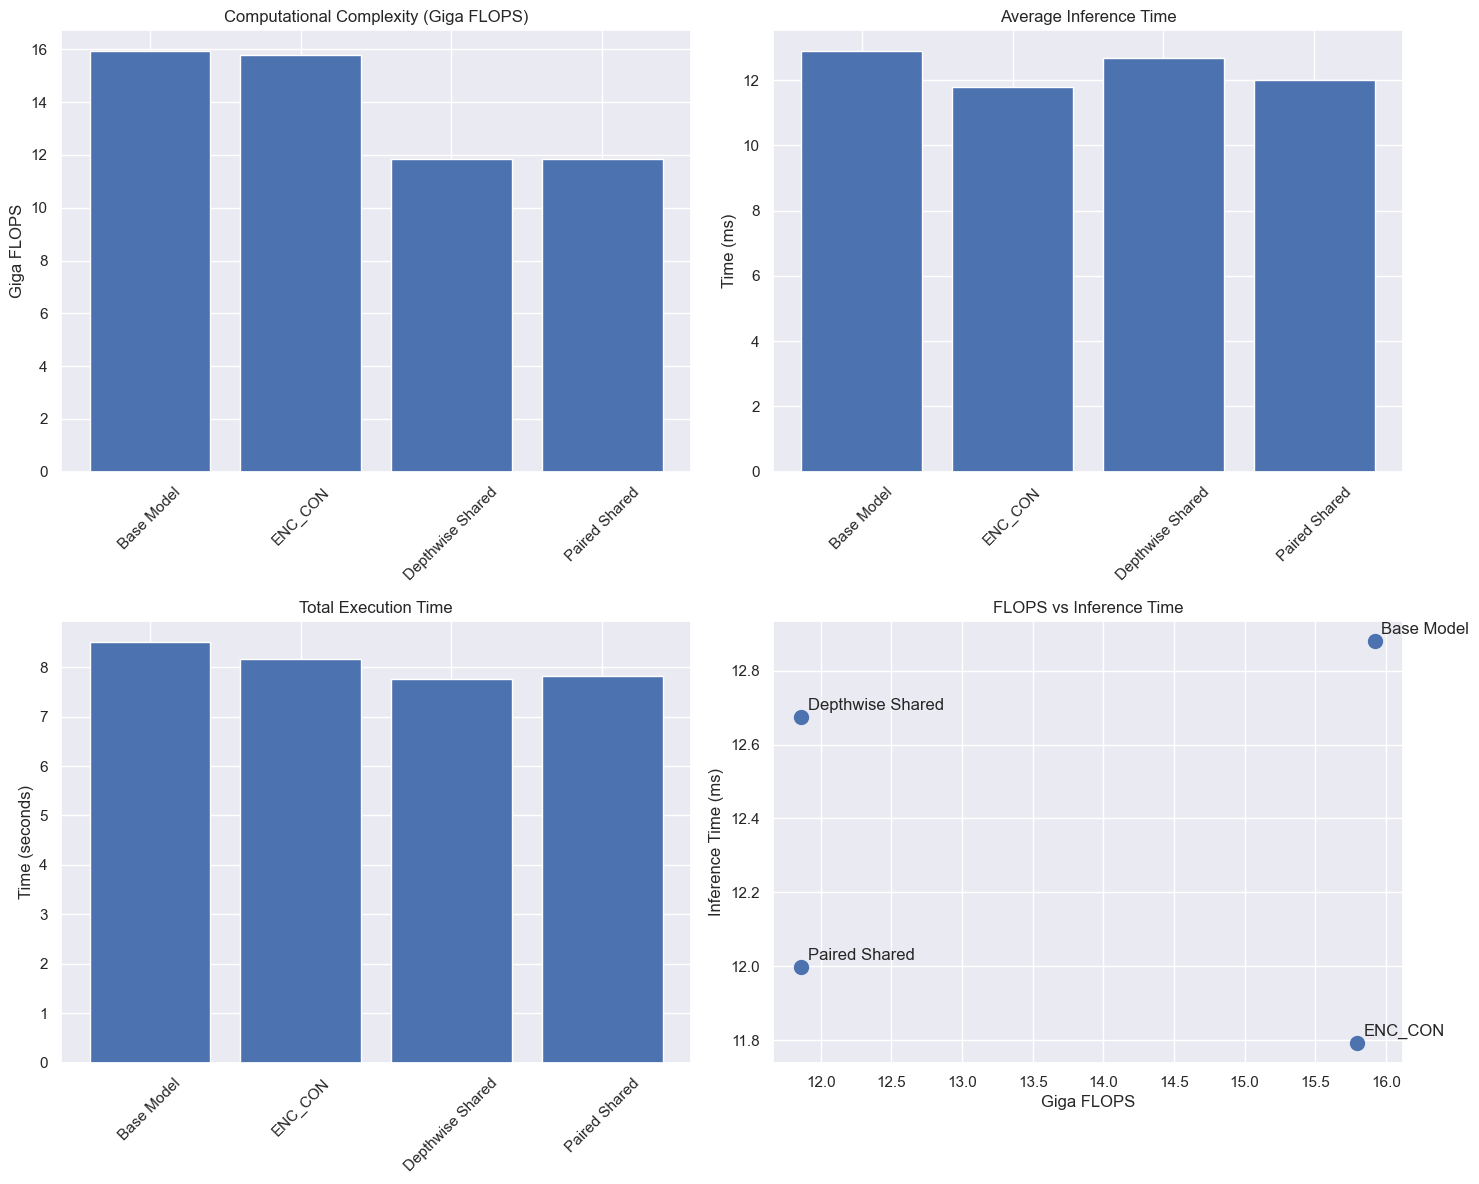


Computational Efficiency Summary:
           Model  FLOPS (G)  Inference Time (ms)  Execution Time (s)  Parameters (M)
      Base Model     15.919               12.879                8.50           8.911
         ENC_CON     15.794               11.793                8.17           6.621
Depthwise Shared     11.863               12.675                7.75           5.046
   Paired Shared     11.863               11.998                7.83           5.051


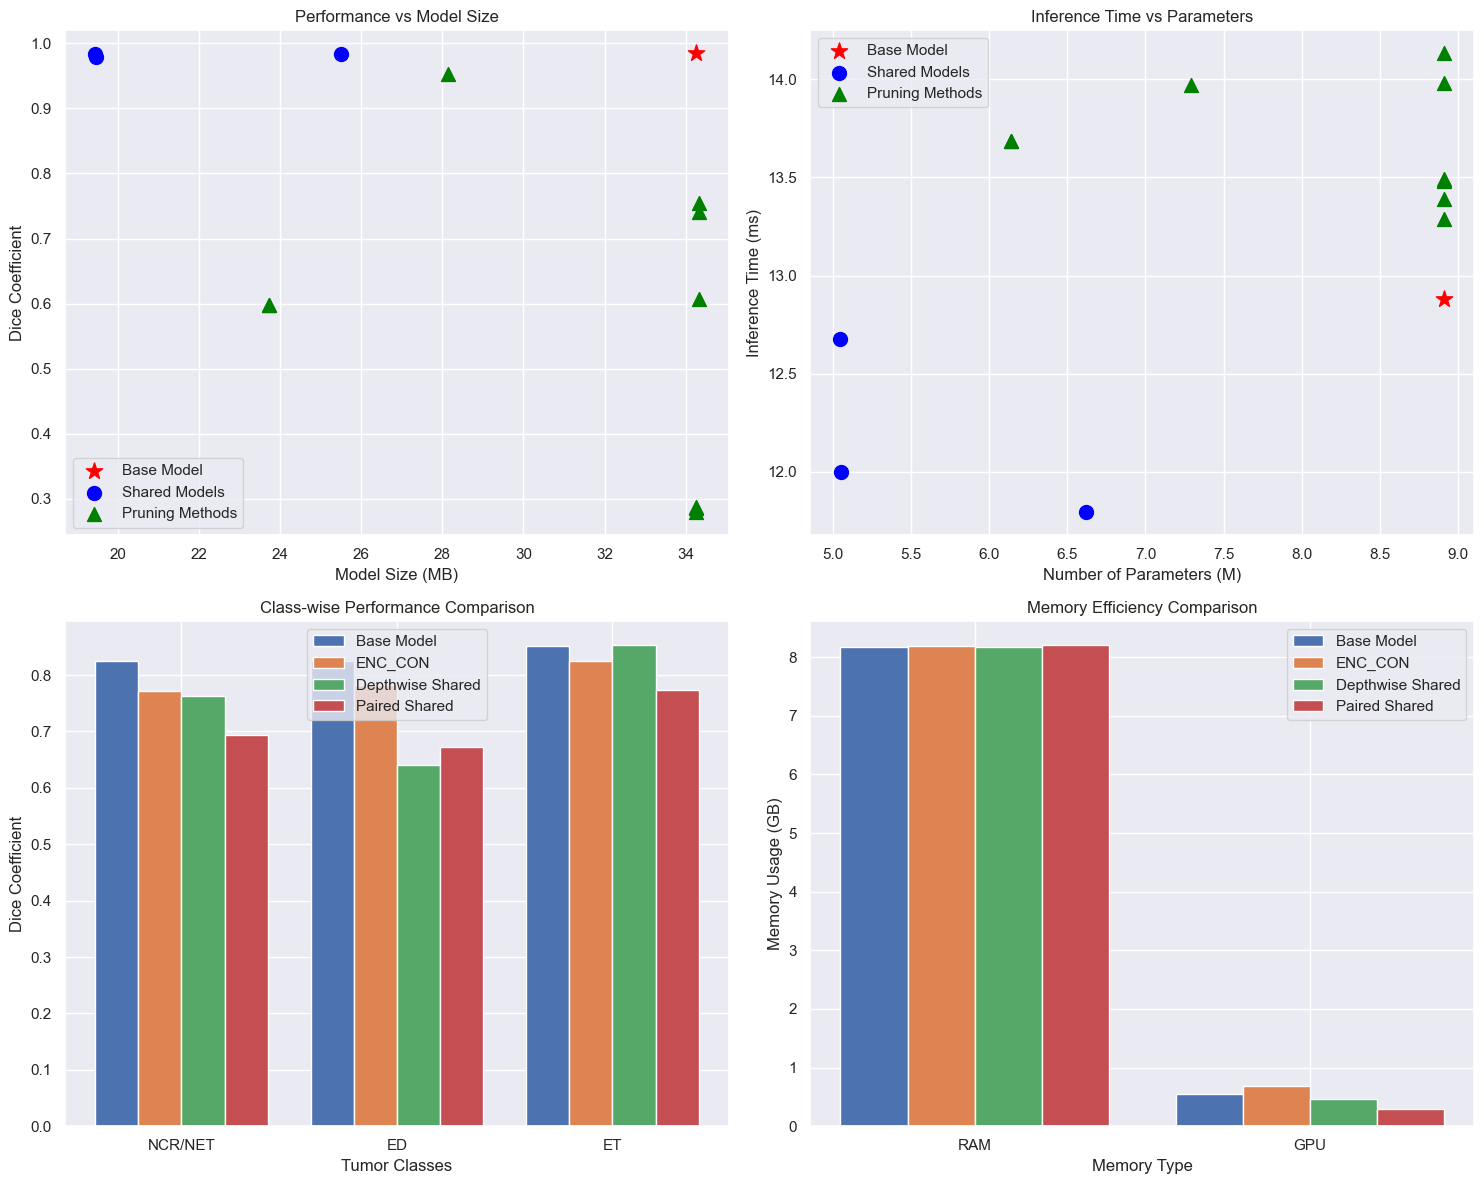


Comparative Analysis Summary:

1. Model Size Reduction:
ENC_CON: 25.6% reduction
Depthwise Shared: 43.2% reduction
Paired Shared: 43.2% reduction

2. Parameter Reduction:
ENC_CON: 25.7% reduction
Depthwise Shared: 43.4% reduction
Paired Shared: 43.3% reduction

3. Performance Impact:
ENC_CON: -0.1% change in Dice coefficient
Depthwise Shared: -0.1% change in Dice coefficient
Paired Shared: -0.6% change in Dice coefficient
All visualizations have been generated successfully!


In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def load_data():
    """Load the model results data from JSON file."""
    with open('model_results.json', 'r') as f:
        return json.load(f)


def create_performance_radar(data):
    """Create a radar chart comparing performance metrics across different models."""
    # Extract metrics for each model variant
    metrics = ['dice_coef', 'mean_iou', 'class_dice']
    models = {
        'Base Model': data['base_model'],
        'ENC_CON': data['enc_con_stats'],
        'Depthwise Shared': data['depthwise_shared'],
        'Paired Shared': data['paired_shared_depthwise']
    }

    # Create radar chart
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # close the loop

    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw=dict(projection='polar'))

    for model_name, model_data in models.items():
        values = [
            model_data['metrics']['dice_coef'],
            model_data['metrics']['mean_iou'],
            np.mean([model_data['metrics']['class_dice'][c]
                    for c in ['c2', 'c3', 'c4']])
        ]
        values = np.concatenate((values, [values[0]]))  # close the loop
        ax.plot(angles, values, 'o-', linewidth=2, label=model_name)
        ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(['Dice Coefficient', 'Mean IoU', 'Average Class Dice'])
    ax.set_ylim(0, 1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.3, 0.3))
    plt.title('Model Performance Comparison')
    plt.show()
    plt.close()


def create_pruning_impact_plot(data):
    """Create line plots showing the impact of pruning on accuracy and efficiency."""
    pruning_methods = ['magnitude_pruning', 'snip_one_shot', 'depgraph']
    ratios = [10, 20, 30]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy vs Pruning Ratio
    for method in pruning_methods:
        dice_scores = [data[method][f'{r}_percent']
                       ['metrics']['dice_coef'] for r in ratios]
        ax1.plot(ratios, dice_scores, 'o-',
                 label=method.replace('_', ' ').title())

    ax1.set_xlabel('Pruning Ratio (%)')
    ax1.set_ylabel('Dice Coefficient')
    ax1.set_title('Accuracy vs Pruning Ratio')
    ax1.grid(True)
    ax1.legend()

    # Efficiency vs Pruning Ratio
    for method in pruning_methods:
        inference_times = [
            data[method][f'{r}_percent']['model_stats']['avg_inference_time_ms'] for r in ratios]
        ax2.plot(ratios, inference_times, 'o-',
                 label=method.replace('_', ' ').title())

    ax2.set_xlabel('Pruning Ratio (%)')
    ax2.set_ylabel('Inference Time (ms)')
    ax2.set_title('Efficiency vs Pruning Ratio')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()
    plt.close()


def create_efficiency_comparison(data):
    """Create a bar chart comparing efficiency metrics across different models."""
    models = {
        'Base Model': data['base_model'],
        'ENC_CON': data['enc_con_stats'],
        'Depthwise Shared': data['depthwise_shared'],
        'Paired Shared': data['paired_shared_depthwise']
    }

    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(models))
    width = 0.25

    # Extract metrics
    model_sizes = [m['model_stats']['model_size_mb'] for m in models.values()]
    inference_times = [m['model_stats']['avg_inference_time_ms']
                       for m in models.values()]
    param_counts = [m['model_stats']['num_params'] /
                    1e6 for m in models.values()]  # Convert to millions

    # Create grouped bars
    ax.bar(x - width, model_sizes, width, label='Model Size (MB)')
    ax.bar(x, inference_times, width, label='Inference Time (ms)')
    ax.bar(x + width, param_counts, width, label='Parameters (M)')

    ax.set_ylabel('Value')
    ax.set_title('Model Efficiency Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models.keys(), rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()
    plt.close()


def create_class_performance_heatmap(data):
    """Create a heatmap showing class-wise performance across different models."""
    models = {
        'Base Model': data['base_model'],
        'ENC_CON': data['enc_con_stats'],
        'Depthwise Shared': data['depthwise_shared'],
        'Paired Shared': data['paired_shared_depthwise']
    }

    classes = ['NCR/NET', 'ED', 'ET']
    performance_matrix = np.zeros((len(models), len(classes)))

    for i, (model_name, model_data) in enumerate(models.items()):
        for j, class_name in enumerate(classes):
            performance_matrix[i,
                               j] = model_data['metrics']['class_dice'][f'c{j+2}']

    plt.figure(figsize=(10, 8))
    sns.heatmap(performance_matrix,
                annot=True,
                fmt='.3f',
                xticklabels=classes,
                yticklabels=models.keys(),
                cmap='YlOrRd')
    plt.title('Class-wise Dice Scores Across Models')
    plt.tight_layout()
    plt.show()
    plt.close()


def create_memory_usage_plot(data):
    """Create a plot comparing memory usage across different models."""
    models = {
        'Base Model': data['base_model'],
        'ENC_CON': data['enc_con_stats'],
        'Depthwise Shared': data['depthwise_shared'],
        'Paired Shared': data['paired_shared_depthwise']
    }

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # RAM Usage
    ram_usage = [m['memory_stats']['peak_ram_gb'] for m in models.values()]
    ax1.bar(models.keys(), ram_usage)
    ax1.set_title('Peak RAM Usage')
    ax1.set_ylabel('RAM (GB)')
    ax1.tick_params(axis='x', rotation=45)

    # GPU Memory Usage
    gpu_usage = [m['memory_stats']['peak_gpu_memory_gb']
                 for m in models.values()]
    ax2.bar(models.keys(), gpu_usage)
    ax2.set_title('Peak GPU Memory Usage')
    ax2.set_ylabel('GPU Memory (GB)')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
    plt.close()


def create_computational_efficiency_plot(data):
    """Create plots comparing computational efficiency metrics across different models."""
    models = {
        'Base Model': data['base_model'],
        'ENC_CON': data['enc_con_stats'],
        'Depthwise Shared': data['depthwise_shared'],
        'Paired Shared': data['paired_shared_depthwise']
    }

    # Create figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. FLOPS Comparison
    flops = [m['model_stats']['flops'] /
             1e9 for m in models.values()]  # Convert to Giga FLOPS
    ax1.bar(models.keys(), flops)
    ax1.set_title('Computational Complexity (Giga FLOPS)')
    ax1.set_ylabel('Giga FLOPS')
    ax1.tick_params(axis='x', rotation=45)

    # 2. Inference Time Comparison
    inference_times = [m['model_stats']['avg_inference_time_ms']
                       for m in models.values()]
    ax2.bar(models.keys(), inference_times)
    ax2.set_title('Average Inference Time')
    ax2.set_ylabel('Time (ms)')
    ax2.tick_params(axis='x', rotation=45)

    # 3. Execution Time Comparison
    execution_times = [m['memory_stats']['execution_time_sec']
                       for m in models.values()]
    ax3.bar(models.keys(), execution_times)
    ax3.set_title('Total Execution Time')
    ax3.set_ylabel('Time (seconds)')
    ax3.tick_params(axis='x', rotation=45)

    # 4. FLOPS vs Inference Time Scatter
    ax4.scatter(flops, inference_times, s=100)
    for i, model_name in enumerate(models.keys()):
        ax4.annotate(model_name, (flops[i], inference_times[i]),
                     xytext=(5, 5), textcoords='offset points')
    ax4.set_xlabel('Giga FLOPS')
    ax4.set_ylabel('Inference Time (ms)')
    ax4.set_title('FLOPS vs Inference Time')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()
    plt.close()

    # Create a summary table
    summary_data = {
        'Model': list(models.keys()),
        'FLOPS (G)': flops,
        'Inference Time (ms)': inference_times,
        'Execution Time (s)': execution_times,
        'Parameters (M)': [m['model_stats']['num_params'] / 1e6 for m in models.values()]
    }

    df = pd.DataFrame(summary_data)
    df = df.round(3)
    print("\nComputational Efficiency Summary:")
    print(df.to_string(index=False))


def create_comparative_analysis(data):
    """Create comparative analysis between shared models, pruning methods, and base model."""
    # Create figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Prepare data
    base_model = data['base_model']
    shared_models = {
        'ENC_CON': data['enc_con_stats'],
        'Depthwise Shared': data['depthwise_shared'],
        'Paired Shared': data['paired_shared_depthwise']
    }
    pruning_methods = {
        'Magnitude (10%)': data['magnitude_pruning']['10_percent'],
        'Magnitude (20%)': data['magnitude_pruning']['20_percent'],
        'Magnitude (30%)': data['magnitude_pruning']['30_percent'],
        'SNIP (10%)': data['snip_one_shot']['10_percent'],
        'SNIP (20%)': data['snip_one_shot']['20_percent'],
        'SNIP (30%)': data['snip_one_shot']['30_percent'],
        'DepGraph (10%)': data['depgraph']['10_percent'],
        'DepGraph (20%)': data['depgraph']['20_percent'],
        'DepGraph (30%)': data['depgraph']['30_percent']
    }

    # 1. Performance vs Model Size
    all_models = {**shared_models, **pruning_methods}
    model_sizes = [m['model_stats']['model_size_mb']
                   for m in all_models.values()]
    dice_scores = [m['metrics']['dice_coef'] for m in all_models.values()]

    # Plot base model
    ax1.scatter(base_model['model_stats']['model_size_mb'],
                base_model['metrics']['dice_coef'],
                s=150, color='red', marker='*', label='Base Model')

    # Plot shared models
    shared_sizes = [m['model_stats']['model_size_mb']
                    for m in shared_models.values()]
    shared_dice = [m['metrics']['dice_coef'] for m in shared_models.values()]
    ax1.scatter(shared_sizes, shared_dice, s=100, color='blue',
                marker='o', label='Shared Models')

    # Plot pruning methods
    pruning_sizes = [m['model_stats']['model_size_mb']
                     for m in pruning_methods.values()]
    pruning_dice = [m['metrics']['dice_coef']
                    for m in pruning_methods.values()]
    ax1.scatter(pruning_sizes, pruning_dice, s=100, color='green',
                marker='^', label='Pruning Methods')

    ax1.set_xlabel('Model Size (MB)')
    ax1.set_ylabel('Dice Coefficient')
    ax1.set_title('Performance vs Model Size')
    ax1.grid(True)
    ax1.legend()

    # 2. Inference Time vs Parameters
    all_params = [m['model_stats']['num_params'] /
                  1e6 for m in all_models.values()]
    inference_times = [m['model_stats']['avg_inference_time_ms']
                       for m in all_models.values()]

    # Plot base model
    ax2.scatter(base_model['model_stats']['num_params'] / 1e6,
                base_model['model_stats']['avg_inference_time_ms'],
                s=150, color='red', marker='*', label='Base Model')

    # Plot shared models
    shared_params = [m['model_stats']['num_params'] /
                     1e6 for m in shared_models.values()]
    shared_times = [m['model_stats']['avg_inference_time_ms']
                    for m in shared_models.values()]
    ax2.scatter(shared_params, shared_times, s=100,
                color='blue', marker='o', label='Shared Models')

    # Plot pruning methods
    pruning_params = [m['model_stats']['num_params'] /
                      1e6 for m in pruning_methods.values()]
    pruning_times = [m['model_stats']['avg_inference_time_ms']
                     for m in pruning_methods.values()]
    ax2.scatter(pruning_params, pruning_times, s=100,
                color='green', marker='^', label='Pruning Methods')

    ax2.set_xlabel('Number of Parameters (M)')
    ax2.set_ylabel('Inference Time (ms)')
    ax2.set_title('Inference Time vs Parameters')
    ax2.grid(True)
    ax2.legend()

    # 3. Class-wise Performance Comparison
    classes = ['NCR/NET', 'ED', 'ET']
    x = np.arange(len(classes))
    width = 0.2

    # Plot base model
    base_class_dice = [base_model['metrics']
                       ['class_dice'][f'c{i+2}'] for i in range(3)]
    ax3.bar(x - width*1.5, base_class_dice, width, label='Base Model')

    # Plot shared models
    for i, (name, model) in enumerate(shared_models.items()):
        class_dice = [model['metrics']['class_dice']
                      [f'c{j+2}'] for j in range(3)]
        ax3.bar(x + width*(i-0.5), class_dice, width, label=name)

    ax3.set_xlabel('Tumor Classes')
    ax3.set_ylabel('Dice Coefficient')
    ax3.set_title('Class-wise Performance Comparison')
    ax3.set_xticks(x)
    ax3.set_xticklabels(classes)
    ax3.legend()

    # 4. Memory Efficiency Comparison
    memory_metrics = ['peak_ram_gb', 'peak_gpu_memory_gb']
    x = np.arange(len(memory_metrics))
    width = 0.2

    # Plot base model
    base_memory = [base_model['memory_stats'][metric]
                   for metric in memory_metrics]
    ax4.bar(x - width*1.5, base_memory, width, label='Base Model')

    # Plot shared models
    for i, (name, model) in enumerate(shared_models.items()):
        memory = [model['memory_stats'][metric] for metric in memory_metrics]
        ax4.bar(x + width*(i-0.5), memory, width, label=name)

    ax4.set_xlabel('Memory Type')
    ax4.set_ylabel('Memory Usage (GB)')
    ax4.set_title('Memory Efficiency Comparison')
    ax4.set_xticks(x)
    ax4.set_xticklabels(['RAM', 'GPU'])
    ax4.legend()

    plt.tight_layout()
    plt.show()
    plt.close()

    # Print summary statistics
    print("\nComparative Analysis Summary:")
    print("\n1. Model Size Reduction:")
    base_size = base_model['model_stats']['model_size_mb']
    for name, model in shared_models.items():
        reduction = (
            (base_size - model['model_stats']['model_size_mb']) / base_size) * 100
        print(f"{name}: {reduction:.1f}% reduction")

    print("\n2. Parameter Reduction:")
    base_params = base_model['model_stats']['num_params']
    for name, model in shared_models.items():
        reduction = (
            (base_params - model['model_stats']['num_params']) / base_params) * 100
        print(f"{name}: {reduction:.1f}% reduction")

    print("\n3. Performance Impact:")
    base_dice = base_model['metrics']['dice_coef']
    for name, model in shared_models.items():
        impact = ((model['metrics']['dice_coef'] -
                  base_dice) / base_dice) * 100
        print(f"{name}: {impact:+.1f}% change in Dice coefficient")


def main():
    """Main function to generate all visualizations."""
    # Set style
    # plt.style.use('seaborn')
    sns.set_theme()

    # Load data
    data = load_data()

    # Create all visualizations
    create_performance_radar(data)
    create_pruning_impact_plot(data)
    create_efficiency_comparison(data)
    create_class_performance_heatmap(data)
    create_memory_usage_plot(data)
    create_computational_efficiency_plot(data)
    create_comparative_analysis(data)

    print("All visualizations have been generated successfully!")


main()
